# But prise en main des objets créés par mes collègues et lancement d'un entrapînement à partir de la BDTOPO ou du RIL en tant que LAbel ??

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q


In [3]:
!pip install pyarrow
!pip install opencv-python
!pip install os-sys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 8.9 MB/s eta 0:00:00:00:0100:01


In [15]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *

ModuleNotFoundError: No module named 'satellite_image'

In [6]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image as im

In [7]:
update_storage_access()

In [8]:
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"])
bucket = environment["bucket"]

path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]


fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [9]:
# DL PLEIADE
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data}",
        lpath=f"../{path_local_pleiades_data}",
        recursive=True)

In [10]:
# DL BDTOPO
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)

## Chargement données pleiades

In [11]:
filename = '../data/PLEIADES/Cayenne/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

datetime.datetime(2022, 7, 20, 0, 0)

In [12]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )
image.normalize()

In [13]:
list_images = image.split(250)
list_images[0].array
len(list_images)

64

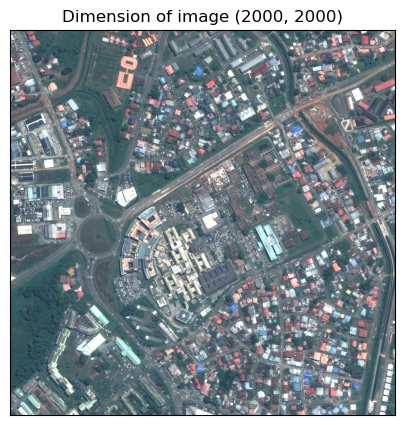

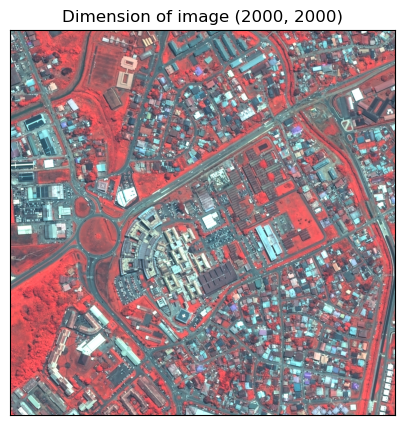

In [303]:
image.plot([0,1,2])
image.plot([3,1,2])

# essayons de créer un masque avec les ondes infrarouges pour l'image 
# un masque binaire avec en blanc les bâtiments

In [14]:
#On veut avoir l'image avec la bande infrarouge en format png pour pouvoir utiliser le package OpenCV

#On va d'abord récuperer l'array avec la bande infrarouge 
#faire un array sans la couleur rouge pour l'image en 51e position de la liste d'images
if not image.normalized:
    image.normalize() 
img = image.array

#avoir la bande infrarouge
img = img[[3,1,2],:, :]

#multiplication par 255 et convertion en uint8 pour avoir le bon format
img = (img * 255).astype(np.uint8)

#convertir l'array en image PIL pour ensuite l'avoir en png
img = im.fromarray(img.transpose(1, 2, 0).astype('uint8'), 'RGB')

#enregistrer l'image en tant que fichier PNG pour pouvoir utiliser OpenCV
img.save('im50.png')

In [15]:
#fonctions d'affichage des images avec OpenCV (la fonction de base cv2.imshow() fait crasher le kernel)

#nuances de gris
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "gray")

#couleurs
def cv2_imshow2(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "brg")


In [32]:
#on lit l'image avec le package OpenCV et on l'affiche
img = cv2.imread('im50.png', cv2.IMREAD_COLOR)

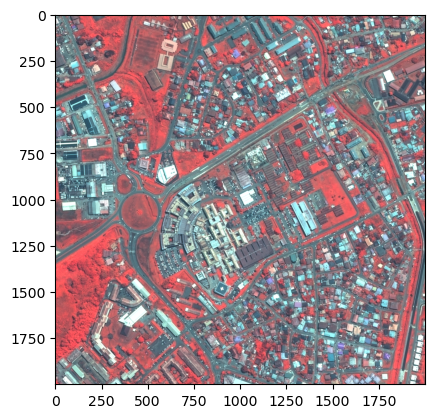

In [17]:
cv2_imshow2(img)

In [33]:
# Parcourir tous les pixels de l'image
for row in range(img.shape[0]):
    for col in range(img.shape[1]):
        # Idée globale : si le pixel est rouge, le changer en noir, le reste en blanc
        
        mini = min(img[row, col, 0],img[row, col, 1])
        if -20 <= (img[row, col, 0] - img[row, col, 1]) <= 20 : #pour que le pixel soit une nuance de rouge, il faut d'abord vérifier si les valeurs verte et bleue sont proches
            if img[row, col, 2] > 230 and mini >= 140 : #pour les nuances de rouge tres claires, on remarque que ce sont des toits donc des bâtiments
                img[row, col] = [255, 255, 255] # blanc
            elif  (img[row, col, 2] - mini)>= 20 and img[row, col, 2] >= 110: #on fixe le seuil de la valeur rouge à 120 et la valeur de rouge avec une autre couleur doit être supérieure à 20 minimum
                img[row, col] = [0, 0, 0] # noir
            else :
                img[row, col] = [255, 255, 255] # blanc

        else :
            img[row, col] = [255, 255, 255] # blanc

/tmp/ipykernel_13564/3979235894.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  elif  (img[row, col, 2] - mini)>= 20 and img[row, col, 2] >= 100: #on fixe le seuil de la valeur rouge à 120 et la valeur de rouge avec une autre couleur doit être supérieure à 20 minimum
/tmp/ipykernel_13564/3979235894.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  if -20 <= (img[row, col, 0] - img[row, col, 1]) <= 20 : #pour que le pixel soit une nuance de rouge, il faut d'abord vérifier si les valeurs verte et bleue sont proches


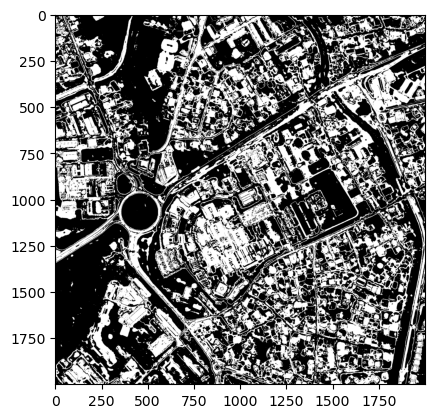

In [34]:
cv2_imshow2(img)

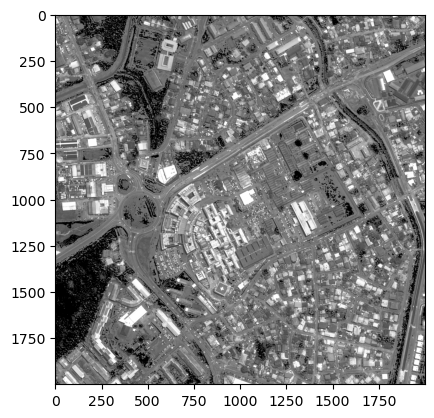

In [332]:
#on la convertit en nuances de gris
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray)

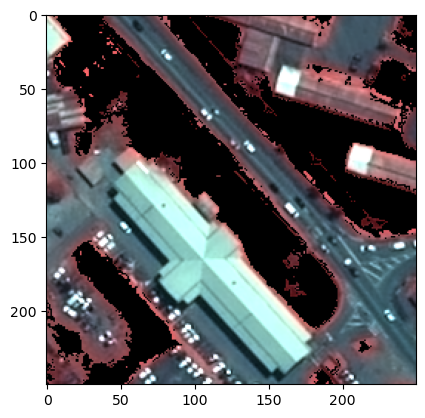

In [306]:
cv2_imshow2(img)

In [276]:
# Converting image to a binary image 
# (black and white only image).
_,threshold = cv2.threshold(gray, 110, 255, 
                            cv2.THRESH_BINARY)

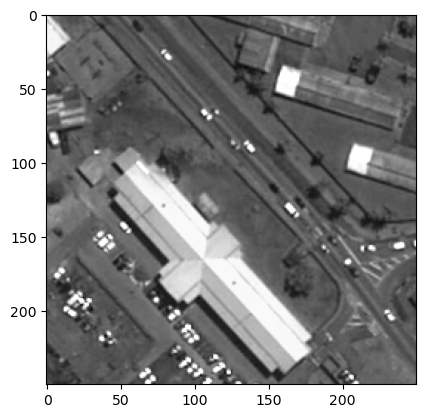

In [277]:
cv2_imshow(gray)

In [278]:
#trouver les contours
contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [294]:
areas = []
for cnt in contours :
    areas.append(cv2.contourArea(cnt))

In [285]:
img = cv2.imread('im50.png', cv2.IMREAD_COLOR)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h,s,v= cv2.split(hsv)
ret_h, th_h = cv2.threshold(h,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_s, th_s = cv2.threshold(s,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_v, th_v = cv2.threshold(s,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imwrite("th_h.png",th_h)
cv2.imwrite("th_s.png",th_s)
cv2.imwrite("th_v.png",th_v)




True

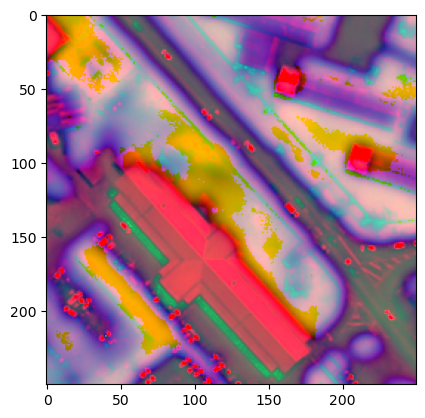

In [298]:
cv2_imshow(hsv)

In [299]:
_,threshold = cv2.threshold(hsv, 110, 255, 
                            cv2.THRESH_BINARY)

In [300]:
#trouver les contours
contours, hierarchy = cv2.findContours(hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [293]:
print(contours)

(array([[[  0,   0]],

       [[  0, 249]],

       [[249, 249]],

       [[249,   0]]], dtype=int32),)


In [295]:
print(areas)

[62001.0]


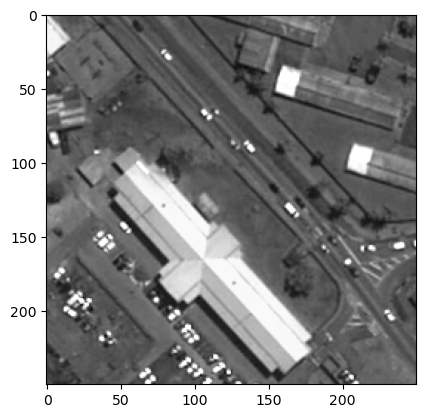

In [279]:
for cnt in contours :
    area = cv2.contourArea(cnt)
   
    # Shortlisting the regions based on there area.
    if area > 100: 
        approx = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
   
        # Checking if the no. of sides of the selected region is 7.
        if(len(approx) == 7): 
            cv2.drawContours(gray, [approx], 0, (0, 0, 255), 5)
            
#montrer l'image avec les polygones
cv2_imshow(gray)

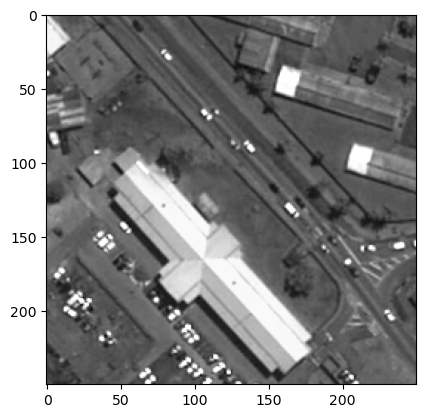

In [273]:
#filtrer les contours
for cnt in contours :
    area = cv2.contourArea(cnt)
   
    # Shortlisting the regions based on there area.
    if area > 20: 
        approx = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
   
        # Checking if the no. of sides of the selected region is 7.
        if(len(approx) == 7): 
            cv2.drawContours(gray, [approx], 0, (0, 255, 0), 5)

#montrer l'image avec les polygones
cv2_imshow(gray)

## Représenter la liste des images sous forme de grille (ajouter une fonction)

In [ ]:
SatelliteImage.plot_list_satellite_images(list_images,bands_indices = [3,1,2])

In [ ]:
64*256 # nb de patchs utilisables pour entrainer un modèle, why not ?

In [ ]:
#image.plot([0,1,2])
image.normalized 

## Récupération des labellisations

In [ ]:
from labeler import RILLabeler

Définition d'une instance de labeller (on donneune datez et un département et on va chercher les labels associés RIL à côté)

In [ ]:
labeler = RILLabeler(date, dep = "973", buffer_size= 20)

Le labeller est chargé une bonne fois pour toute donc pas de problème

In [ ]:
mask = labeler.create_segmentation_label(image) # va chercher les données et rasterise les bounding box

In [ ]:
image.normalize
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array_to_plot, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

# Plus qu'à faire la même chose sur le mont baduel :)

In [ ]:
filename = '../data/PLEIADES/Cayenne/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0354_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )

image.plot([3,1,2])

In [ ]:
SatelliteImage.plot_list_satellite_images(image.split(250),[0,1,2])

## Plot liste satellite images

Ici je teste la fonction plot list satellite image maius sur l'ensmeble des images disponible sur Cayenne
1) Je mets toutes les images dans une liste de satellite images
2) je trace le quadrillage

In [ ]:
im_dir = "../data/PLEIADES/Cayenne/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = np.array([im_dir+l for l in liste])


liste_globale_image = [ SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 3,
        dep = "973"
    ) for filename in list_path_image]


In [ ]:
i = 0
for im in liste_globale_image:
    print(i)
    i = i + 1
    im.normalize()

In [ ]:
SatelliteImage.plot_list_satellite_images(liste_globale_image,[0,1,2])

In [ ]:
del liste_globale_image

## Ril

In [ ]:
from labeler import RILLabeler
labeler = RILLabeler(date, dep = "973", buffer_size= 20)
mask = labeler.create_segmentation_label(image)
image.normalize()
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

## BD TOPO

In [ ]:
from labeler import BDTOPOLabeler

In [ ]:
labeler_bdtopo = BDTOPOLabeler(date, dep = "973") # charghement lenbt nécessite d'avoir downloader la BDTOPO avant. fluidifier ça ?

In [ ]:
mask = labeler_bdtopo.create_segmentation_label(image)

In [ ]:
if image.normalize == False:
    image.normalize
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

Le chargement lent milite pour repréparer le jeu de données en amont une fois qu'on est fixé sur la taille avant de créer les Dataset etc..

Le moint Baduel a bien été cartographié !

## Mélange images Labels !

In [ ]:
from labeled_satellite_image import SegmentationLabeledSatelliteImage

Ok ici on a des objets qui fonct cohabiter image et son label (image + segmentation mask (RIL ou BDTOPO))
On pourra faire la même chose avec la detection ou l'optique patchs etc..(il nous faut des fonctions de représentation à chaque fois) 

- de superposition image et label
- et de mise cote à cote
- possibnilité de revenir à la géométrie à chaque fois


In [ ]:
#image.normalize()
image_labellisee = SegmentationLabeledSatelliteImage(image,label = mask, labeling_date = date, source = "BDTOPO")


In [ ]:
# 1) plot image et masque superposés
image_labellisee.plot([0,1,2])

# 2) plot image et masque associés côte à côte
image_labellisee.plot_label_next_to_image([0,1,2])


## fonction split

In [ ]:
liste_image_labelisee = image_labellisee.split(250)
len(liste_image_labelisee)

## Plot liste image labellisée 

In [ ]:
SegmentationLabeledSatelliteImage.plot_list_segmentation_labeled_satellite_image(liste_image_labelisee,[0,1,2])

## Plot les masques de détection

## TO DO 
- Vérifier si ma fonction plot list images s'adapte à la,liste d'image globale
- création d'une classe Dataset particulière 
- comment créer un DataSet à partir des images originales ? utiliser des fonctions split successives, stacker etc..mais on ne va pas tout garder en mémoire.. création de nouveaux fichiers image ? ou bien technique 2 splitter et sélectionner aléatoirement une ou plusieur zones dans l'image ? -> voir avec les gars
- Faire une fonction create bounding box pour yolo etc.. c'est l'objet de create detection label , faire une fonction de représentation ?
- access Vault ? -W> dans projet slums detection bidonvilles
- Faire un notebook de prise en main pour les stagiaires -> en cours
- faire une fonction plot label on images (superposition)
- faire une fonction plot label next to image -> done
- faire une fonction plot liste image -> done
- fair eune fonction plot list of label images
- faire une fonction qui a partir d'un masque de segmentation donné sors les polygones associés (revenir sur rasterio ?)
- Pour les datasets, les classes faire une classe généralsite Dataset Segmentation et détection et patchs
- et faire plusieurs types de dataset segmentation dépendant du jeu de données et la stratégie de chargement
- ppour les modèles il faudra faire une surclasse modeles segment ation/detection et créer des modèlmes ad hoc etc.. De telle sorte qu'un modèle de segmentation puisse s'appliquer sans douleur sur un dataset de segmentation